# Channel-Layer-Oriented Lightweight Spectral-Spatial Network for Hyperspectral Image Classification

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.model_selection
from torch.nn import init
from torch.backends import cudnn
from operator import truediv
from tqdm import tqdm
import os
from scipy import io
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from timm.layers import weight_init, DropPath
from timm.models.registry import register_model
import random
import time
from thop import profile
from torchsummary import summary
device = torch.device('cuda:{}'.format(0))
random.seed(7)
torch.manual_seed(7)
torch.cuda.manual_seed(7)
np.random.seed(7)
cudnn.deterministic = True

# 1. Load data

## 1.1 Load img and gt as numpy.ndarray

In [2]:
datasets = {
        'PaviaU': {
            'img': 'PaviaU.mat',      #paviaU
            'gt': 'PaviaU_gt.mat'     #paviaU_gt
            },
        'houston2013':{
            'img': 'houston2013.mat', # houston2013
            'gt': 'DFC2013_gt.mat'# DFC2013_gt
        },
        'salinas':{
            'img': 'Salinas.mat', # salinas
            'gt': 'Salinas_gt.mat'# salinas_gt
        },
        'WHHC':{
            'img': 'hanchuan_half.mat', # hanchuan_half
            'gt': 'hanchuan_half_gt.mat'# half_new
        },
        'Dioni':{
            'img': 'Dioni.mat', # ori_data
            'gt': 'Dioni_gt_out68.mat'# map
        },
        'MUUFL':{
            'img': 'MUUFL.mat', # data
            'gt': 'MUUFL_gt.mat'# labels
        } 
}
dataset_name='houston2013'
dataset=datasets[dataset_name]
folder =  './Datasets/'
img = io.loadmat(folder+dataset['img'])['houston2013']   

img= (img - np.min(img))/(np.max(img)-np.min(img))  
print(type(img),img.shape)
gt = io.loadmat(folder + dataset['gt'])['DFC2013_gt']

<class 'numpy.ndarray'> (349, 1905, 144)


## 1.2 Visualization

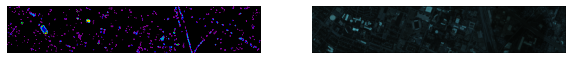

In [3]:
N_CLASSES = max(np.unique(gt))
N_BANDS = img.shape[-1]      
fig=plt.figure(num=1,figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(gt,cmap='nipy_spectral')
plt.axis('off')
plt.subplot(2,2,2)
# plt.imshow(img[:,:,(10, 50, 100)]) 
plt.imshow(img[:,:,(10, 20, 30)]) 
plt.axis('off')
plt.show()

## 1.3 Training set ,validation set and test set split

In [4]:
indices = np.nonzero(gt)
X = list(zip(*indices))
y = gt[indices] 
train_gt = np.zeros_like(gt)
test_gt = np.zeros_like(gt)
val_gt = np.zeros_like(gt)
print('train_gt: ',type(train_gt),train_gt.shape)

train_indices, test_indices = sklearn.model_selection.train_test_split(X, train_size=0.05, random_state=12,stratify=y)

val_size = len(train_indices)
val_indices = test_indices[-val_size:]
test_indices = test_indices[:-val_size]

train_size = len(train_indices)
train_indices = list(zip(*train_indices))
val_indices = list(zip(*val_indices))
test_indices = list(zip(*test_indices))

train_gt[train_indices] = gt[train_indices]
val_gt[val_indices] = gt[val_indices]
test_gt[test_indices] = gt[test_indices]

# GHOSTNET&LS2CM Training set for hous2013
# train_gt = io.loadmat(folder+'TR_hous2013_5.mat')['Tr1'] 
# val_gt = io.loadmat(folder+'TV_hous2013_5.mat')['Tv1'] 
# test_gt = io.loadmat(folder+'TE_hous2013_5.mat')['Te_new1'] 


train_gt:  <class 'numpy.ndarray'> (349, 1905)


D:\anaconda3\envs\pytorch_envs\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
D:\anaconda3\envs\pytorch_envs\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
D:\anaconda3\envs\pytorch_envs\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result e

## 1.4 Define dataloader

In [5]:
class HSIdata(torch.utils.data.Dataset):
    def __init__(self,data,gt):
        super(HSIdata, self).__init__()
        self.data = data   
        self.label = gt-1
        self.patch_size = 13
        self.data_all_offset = np.zeros((data.shape[0] + self.patch_size - 1, self.data.shape[1] + self.patch_size - 1, self.data.shape[2]))
        self.start = int((self.patch_size - 1) / 2)
        self.data_all_offset[self.start:data.shape[0] + self.start, self.start:data.shape[1] + self.start, :] = self.data[:, :, :]
        x_pos, y_pos = np.nonzero(gt)
    
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos)])
        self.labels = [self.label[x,y] for x,y in self.indices]
        
#         np.random.shuffle(self.indices)
        
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size

        data = self.data_all_offset[x:x+self.patch_size, y:y+self.patch_size]
        label = self.label[x, y]
        data = np.asarray(data.transpose((2, 0, 1)), dtype='float32')
        label = np.asarray(label, dtype='int64')
        data = torch.from_numpy(data)
        label = torch.from_numpy(label)
#         print(type(data[6,6,1]),data.shape)
#         print(label)
        return data, label,x,y

train_dataset = HSIdata(img, train_gt)
train_loader = torch.utils.data.DataLoader(train_dataset,
                               batch_size=32,
                               shuffle=True)

val_dataset = HSIdata(img, val_gt)
val_loader = torch.utils.data.DataLoader(val_dataset,
                               batch_size=32,
                               shuffle=True)

test_dataset = HSIdata(img, test_gt)
test_loader = torch.utils.data.DataLoader(test_dataset,
                               batch_size=256,
                               shuffle=True)

all_gt_dataset = HSIdata(img,gt)
all_loader = torch.utils.data.DataLoader(all_gt_dataset,
                               batch_size=256,
                               shuffle=True)


# 2. Define Network structure 

In [6]:
class SELayer(nn.Module):

    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        out = channel // reduction
        if out == 0:
            out = 1
        self.fc = nn.Sequential(
            nn.Linear(channel, out, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(out, channel, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y=self.avg_pool(x).view(b,c)
        y=self.fc(y).view(b,c,1,1)
        return x*y.expand_as(x)
    
class COS2M(nn.Module):
    def __init__(self, input_channels ,reduction_N = 16):
        super(COS2M, self).__init__()
        self.point_wise = nn.Conv2d(input_channels,reduction_N,kernel_size=1,padding=0,bias=False)
        self.depth_wise = nn.Conv2d(reduction_N, reduction_N, kernel_size=3, padding=1, groups=reduction_N, bias=False)      
        self.conv3D = nn.Conv3d(in_channels=1, out_channels=1, kernel_size=(1,1,3),padding=(0,0,1),stride=(1,1,1),bias=False)
        self.bn = nn.BatchNorm2d(reduction_N)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        x_1 = self.point_wise(x)  
        x_2 = self.depth_wise(x_1)
        #DSC
        x_3 = x_1.unsqueeze(1)
        x_3 = self.conv3D(x_3)
        x_3 = x_3.squeeze(1)
        
        x = torch.cat((x_2,x_3),dim=1)
        
        return x

class NPAF(nn.ReLU):
    def __init__(self, dim, act_num=1):
        super(NPAF, self).__init__()
        self.act_num = act_num
        self.dim = dim
        self.weight = torch.nn.Parameter(torch.randn(dim, 1, act_num*2 + 1, act_num*2 + 1))
        self.bias = None
        self.bn = nn.BatchNorm2d(dim, eps=1e-6)
        weight_init.trunc_normal_(self.weight, std=.02)

    def forward(self, x):
        return self.bn(torch.nn.functional.conv2d(
            super(NPAF, self).forward(x),
            self.weight, padding=self.act_num, groups=self.dim))


class BaseNet(nn.Module):

    def __init__(self, input_channels, n_classes, dropout=True):
        super(BaseNet, self).__init__()
        self.use_dropout = dropout
        if dropout:
            self.dropout = nn.Dropout(p=0.4)
          
        self.lwm = COS2M(input_channels)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.act1 = NPAF(32)

        self.lwm2 = COS2M(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.se0 = SELayer(32)  
               
        self.conv3 = nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0, bias=False)
        self.mask3 = nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0, bias=False)
#         self.mask3.weight.data = torch.ones(self.mask3.weight.size())
        self.bn3 = nn.BatchNorm2d(16)
        self.act2 = NPAF(16)
        self.se1 = SELayer(16)
    
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(16, n_classes ,bias=False)

    def forward(self, x):

        x1 = self.lwm(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)

        x2 = self.lwm2(x1)
        x2 = self.bn2(x2)
        x2 = self.act1(x2)
        x2=self.se0(x2)
        
        x3 = self.conv3(x2)
        x3 = self.bn3(x3)
        x3 = self.act2(x3)
        x3=self.se1(x3)
        if self.use_dropout:
            x3 = self.dropout(x3)
            
        x3 = self.avgpool(x3)
        x3 = x3.view(x3.size(0), -1)
        x3 = self.fc1(x3)
        
        return x3


# 3. Utils

In [7]:
def save_model(model, model_name, dataset_name, epoch):
    model_dir = './checkpoints/' + model_name + "/" + dataset_name + "/"
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir, exist_ok=True)
    filename = str('w6') + "_epoch{}".format(epoch)
    print(filename)
    torch.save(model.state_dict(), model_dir + filename + '.pth')
    
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

# 4. Train define

In [8]:
def evaluate_accuracy(data_loader, net, loss):
#     val_loss = 0
    number = 0
    acc_sum = 0   
    test_num = 0
    with torch.no_grad():
        for iter_, (data, target,x,y) in enumerate(data_loader):
            val_loss = 0
            data, target = data.to(device), target.to(device)            
            net.eval()
            output = net(data)
            l = loss(output, target.long())
            acc_sum += (output.argmax(dim=1) == target.to(device)).float().sum().cpu().item()          
#             l = loss(output, target)
#             _, predicts = torch.max(output.data, 1)
            val_loss = val_loss + l
            number += len(target)
#             correct = correct + (predicts == target).sum()
            net.train()
            test_num += 1
        
    return [acc_sum / number, val_loss.cpu()]


def train(net, optimizer, critirian, data_loader, val_loader, epoch):
    loss_list = [1000]
    early_epoch = 0
    early_num = 20 
    early_stopping = 1
    train_loss_list = []
    valida_loss_list = []
    train_acc_list = []
    valida_acc_list = []
    net.to(device)
    for e in range(1, epoch + 1):
        net.train()
        lr_adjust = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 15, eta_min=0.0, last_epoch=-1)
        avg_loss = 0
        number = 0
        correct = 0
        for iter_, (data, target,x,y) in enumerate(data_loader):
            batch_count, train_l_sum = 0, 0
            data, target = data.to(device), target.to(device)            
            optimizer.zero_grad()
            output = net(data)
            #             print(target)
            loss = critirian(output, target)
            loss.backward()
            optimizer.step()
            _, predicts = torch.max(output.data, 1)
            avg_loss = avg_loss + loss.item()
            number += len(target)
            correct = correct + (predicts == target).sum()
            
        lr_adjust.step(epoch)
        valida_acc, valida_loss = evaluate_accuracy(val_loader, net, critirian)
        loss_list.append(valida_loss)
        avg_loss /= len(data_loader)     
        print('train--------')
#         print('Epoch:', e, 'loss:', avg_loss)
        acc = correct.item() / number
    
        train_loss_list.append(avg_loss)
        train_acc_list.append(acc)
        valida_loss_list.append(valida_loss)
        valida_acc_list.append(valida_acc)

#         print('Epoch:', e, 'acc:', acc)
        print('epoch %d, train loss %.6f, train acc %.3f, valida  loss %.6f, valida acc %.3f'% (e + 1, avg_loss, acc, valida_loss, valida_acc))    
#         filename = str('LW') + "_epoch{}".format(e)
        PATH = "./LW_best_net.pt"
        global best_acc
        if valida_acc > best_acc:
            best_acc = valida_acc
            torch.save(net.state_dict(), PATH)
        if e == epoch:
            net.load_state_dict(torch.load(PATH))      
   
        if e % 100 == 0:
            save_model(net, 'basenet', dataset_name, e)
            


# 5.TRAIN & TEST

D:\anaconda3\envs\pytorch_envs\lib\site-packages\torch\optim\lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


train--------
epoch 2, train loss 2.592300, train acc 0.236, valida  loss 2.682404, valida acc 0.093
train--------
epoch 3, train loss 2.451349, train acc 0.397, valida  loss 2.725243, valida acc 0.121
train--------
epoch 4, train loss 2.318637, train acc 0.462, valida  loss 2.253882, valida acc 0.258
train--------
epoch 5, train loss 2.195142, train acc 0.534, valida  loss 2.240393, valida acc 0.397
train--------
epoch 6, train loss 2.070874, train acc 0.574, valida  loss 1.898215, valida acc 0.498
train--------
epoch 7, train loss 1.926607, train acc 0.610, valida  loss 1.955746, valida acc 0.558
train--------
epoch 8, train loss 1.828052, train acc 0.606, valida  loss 2.095177, valida acc 0.433
train--------
epoch 9, train loss 1.725234, train acc 0.617, valida  loss 1.523797, valida acc 0.434
train--------
epoch 10, train loss 1.650967, train acc 0.617, valida  loss 1.394747, valida acc 0.594
train--------
epoch 11, train loss 1.541175, train acc 0.646, valida  loss 1.913732, valid

train--------
epoch 83, train loss 0.244941, train acc 0.931, valida  loss 0.841079, valida acc 0.736
train--------
epoch 84, train loss 0.235998, train acc 0.925, valida  loss 0.485420, valida acc 0.828
train--------
epoch 85, train loss 0.241916, train acc 0.925, valida  loss 0.575901, valida acc 0.903
train--------
epoch 86, train loss 0.192183, train acc 0.952, valida  loss 0.043671, valida acc 0.912
train--------
epoch 87, train loss 0.231139, train acc 0.933, valida  loss 0.122797, valida acc 0.927
train--------
epoch 88, train loss 0.212223, train acc 0.941, valida  loss 2.592773, valida acc 0.650
train--------
epoch 89, train loss 0.233989, train acc 0.937, valida  loss 0.565912, valida acc 0.871
train--------
epoch 90, train loss 0.203710, train acc 0.940, valida  loss 0.047372, valida acc 0.923
train--------
epoch 91, train loss 0.164955, train acc 0.961, valida  loss 0.215113, valida acc 0.955
train--------
epoch 92, train loss 0.198708, train acc 0.951, valida  loss 0.49109

train--------
epoch 163, train loss 0.118438, train acc 0.971, valida  loss 1.212252, valida acc 0.767
train--------
epoch 164, train loss 0.166974, train acc 0.944, valida  loss 0.068270, valida acc 0.924
train--------
epoch 165, train loss 0.102517, train acc 0.976, valida  loss 0.294492, valida acc 0.944
train--------
epoch 166, train loss 0.071583, train acc 0.981, valida  loss 0.022922, valida acc 0.940
train--------
epoch 167, train loss 0.097582, train acc 0.972, valida  loss 0.173114, valida acc 0.933
train--------
epoch 168, train loss 0.108144, train acc 0.971, valida  loss 0.458795, valida acc 0.783
train--------
epoch 169, train loss 0.135510, train acc 0.955, valida  loss 0.089837, valida acc 0.941
train--------
epoch 170, train loss 0.136400, train acc 0.957, valida  loss 0.276292, valida acc 0.795
train--------
epoch 171, train loss 0.089057, train acc 0.984, valida  loss 1.405744, valida acc 0.783
train--------
epoch 172, train loss 0.179146, train acc 0.956, valida  lo

train--------
epoch 243, train loss 0.083565, train acc 0.980, valida  loss 0.028311, valida acc 0.937
train--------
epoch 244, train loss 0.092771, train acc 0.976, valida  loss 0.082786, valida acc 0.935
train--------
epoch 245, train loss 0.058619, train acc 0.983, valida  loss 0.474755, valida acc 0.921
train--------
epoch 246, train loss 0.095942, train acc 0.972, valida  loss 0.039988, valida acc 0.932
train--------
epoch 247, train loss 0.072651, train acc 0.983, valida  loss 0.977666, valida acc 0.683
train--------
epoch 248, train loss 0.210566, train acc 0.945, valida  loss 1.202133, valida acc 0.885
train--------
epoch 249, train loss 0.088427, train acc 0.971, valida  loss 0.178957, valida acc 0.909
train--------
epoch 250, train loss 0.094015, train acc 0.973, valida  loss 0.222739, valida acc 0.957
train--------
epoch 251, train loss 0.082755, train acc 0.981, valida  loss 0.348087, valida acc 0.893
train--------
epoch 252, train loss 0.075663, train acc 0.976, valida  lo

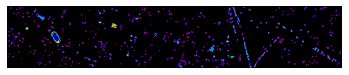

In [9]:
base_net=BaseNet(N_BANDS,N_CLASSES)
critirian=nn.CrossEntropyLoss().cuda()
lr=0.05
epochs=300
optimizer=torch.optim.SGD(base_net.parameters(),lr=lr,weight_decay=0.0001)
best_acc=0
kappa=0
cls_report=''
train_acc_list=[]
test_acc_list=[]
tic0 = time.perf_counter()
train(base_net,optimizer,critirian,train_loader,val_loader,epochs)
toc0 = time.perf_counter()
time_train = toc0 - tic0

tic = time.perf_counter()
number = 0
correct = 0
predicts = np.zeros((0))
targets = np.zeros((0))
indicesX = []
indicesY = []
with torch.no_grad():
    for iter_, (data, target,x,y) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        base_net.eval()
        output = base_net(data)
        _, predict = torch.max(output.data, 1)
        predict = predict.cpu().numpy()
        target = target.cpu().numpy()
        predicts = np.append(predicts, predict)
        targets = np.append(targets, target)
        indicesX.extend(x.cpu().numpy().tolist())
        indicesY.extend(y.cpu().numpy().tolist())
toc = time.perf_counter()
time_test = toc - tic
predicts = predicts.tolist()

targets = targets.tolist()
acc = accuracy_score(predicts, targets)
test_acc_list.append(acc)
toc = time.perf_counter()
time_test = toc - tic
print('test-------')
# print('Epoch:', epoch)
print('test Acc:', acc)
kappa = cohen_kappa_score(predicts, targets)
print('Kappa', kappa)
con_matrics = confusion_matrix(predicts, targets)
each_acc, aa = AA_andEachClassAccuracy(con_matrics)
cls_report = classification_report(predicts, targets, digits=4)
#         print(con_matrics)
#         print(cls_report)
print('aa:',aa)
print('each acc:',each_acc)
print('train time:',time_train)
print('test time:',time_test)

X = np.array(indicesX)
Y = np.array(indicesY)
test_img = gt
predicts_cor = [i+1 for i in predicts]
test_img[X[:], Y[:]] = np.array(predicts_cor)
plt.imshow(test_img, cmap='nipy_spectral')
plt.axis('off')
# plt.title("epoch:{}".format(epoch))
plt.show()


# classification maps for all pixels in the image

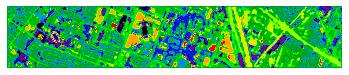

In [12]:
y_temp = np.ones_like(gt)
all_dataset = HSIdata(img,y_temp)
all_map_loader = torch.utils.data.DataLoader(all_dataset,
                               batch_size=256,
                               shuffle=True)

number = 0
correct = 0
predicts = np.zeros((0))
targets = np.zeros((0))
indicesX = []
indicesY = []
with torch.no_grad():
    for iter_, (data, target,x,y) in enumerate(all_map_loader):
        data, target = data.to(device), target.to(device)
        base_net.eval()
        output = base_net(data)
        _, predict = torch.max(output.data, 1)
        predict = predict.cpu().numpy()
        target = target.cpu().numpy()
        predicts = np.append(predicts, predict)
        targets = np.append(targets, target)
        indicesX.extend(x.cpu().numpy().tolist())
        indicesY.extend(y.cpu().numpy().tolist())

predicts = predicts.tolist()
X = np.array(indicesX)
Y = np.array(indicesY)
test_img = gt
predicts_cor = [i+1 for i in predicts]
test_img[X[:], Y[:]] = np.array(predicts_cor)
plt.imshow(test_img, cmap='nipy_spectral')
plt.axis('off')
plt.show()
io.savemat( dataset_name + '_CLOLN_classmap.mat', {"classes_map": test_img})


In [13]:
torch.save(base_net, "./savenet/CLOLN_best_net.pt")

# model complexity

In [14]:
input_x = torch.randn(1, N_BANDS, 13, 13)
input_x = input_x.cuda()
macs,_ = profile(base_net, inputs=(input_x, ))
print("MACs are about",macs,'and should add the MACs of NAPF manually, the rules of that can refer the paper')
summary(base_net, input_size=(N_BANDS,13,13))

[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv3d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class '__main__.COS2M'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.NPAF'>. Treat it as zero Macs and zero Params.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Sigmoid'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <cla